# Talking with our data

The ability to ask questions of our data using our everyday language is the StarTrek dream, isn't it. 'Computer, when and how was this site abandoned?' Using more sophisticated models than what we used when doing our [[practical-necromancy.ipynb]] we can, kinda.

The Harris Matrix is a remarkable tool. Not only does it help us make sense of the data, it can help the machine as well. Just as we did with the images, we turn each archaeological context into a vector, and express all of these vectors in the embedding space. Then we can use an LLM to express our _query_ in the same embedding space, find the contexts that are closest to it, and then constrain the LLM to generate a response using only the information from those contexts.

---

This notebook represents a prototype of a RAG system for archaeological context data with the following capabilities:

1. **Data Processing**: Loads and prepares archaeological context data with stratigraphic relationships
2. **Embedding Generation**: Creates semantic embeddings using Simon Willison's LLM package
3. **Similarity Search**: Finds contextually similar archaeological contexts
4. **RAG Query System**: Answers natural language questions about the archaeological record
5. **Visualization**: Provides insights into the embedding space and stratigraphic relationships
6. **Persistence**: Saves embeddings and results for future use

### Features:
- **Stratigraphic Understanding**: Incorporates complex archaeological relationships
- **Semantic Search**: Find contexts by meaning, not just keywords
- **Interactive Querying**: Natural language interface for archaeological research
- **Visualization**: 2D projections of the embedding space
- **Extensible**: Easy to add new contexts and query types

...well, that's the theory, anyway...

### Potential Extensions:
- Implement temporal sequence analysis
- Include geographic/spatial relationships
- Add support for multiple sites and comparative analysis
- Integrate with archaeological databases and standards
- use Ollama, faster models?

### Usage Tips:
1. Ensure your CSV has the expected columns or modify the `prepare_context_text` function
2. Set up your OpenAI API key: `llm keys set openai` if you use those models. In the code, you'll see that I also show how to use models from the Groq service as well. The default model is the Orca model which can run on many laptops, so no keys required.
3. Adjust the embedding model based on your needs (quality vs. cost)
4. Experiment with different query formulations for best results
5. Use the visualization tools to understand your data's structure

### If your machine can't run this
Don't worry: there's a version set up with the [Google Colab service using a GPU that you can try, behind this link.](https://colab.research.google.com/drive/1XNFBcEb7qbYK-soNmyfSwjDR94n0ROIh?usp=sharing)


In [5]:
# Install required packages ; takes a few moments
%%capture
!pip install llm pandas numpy scikit-learn matplotlib seaborn
!llm install llm-sentence-transformers #which gives us the all-MiniLM-L6-v2 embedding model as default
!llm install llm-gpt4all #which gives us a variety of other models; we'll want orca-mini-3b-gguf2-q4_0 because it's small ... but it is slow.

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import sqlite3
from pathlib import Path
from typing import List, Dict, Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import llm
from typing import List, Dict, Any, Optional

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [7]:
## 1. Data Loading and Preprocessing

## We're assuming input data created using Graham's Harris Matrix Tool
## at https://shawngraham.github.io/homecooked-history/hm-generator-site/enhanced.html

def load_archaeological_data(csv_path: str) -> pd.DataFrame:
    """
    Load archaeological context data from CSV file.

    Expected columns:
    - Context_ID: Unique identifier for each archaeological context
    - Context_Type: Type of context (layer, cut, fill, etc.)
    - Description: Detailed description of the context
    - Earliest_Date_Year: Earliest possible date (year)
    - Earliest_Date_Era: Era for earliest date (BC/AD)
    - Latest_Date_Year: Latest possible date (year)
    - Latest_Date_Era: Era for latest date (BC/AD)
    - Date_Type: Type of dating evidence
    - Phase_ID: Phase identifier
    - Phase_Name: Phase name/description
    - Group_ID: Group identifier
    - Group_Name: Group name/description
    - Sub-Group_ID: Sub-group identifier
    - Sub-Group_Name: Sub-group name/description
    - Relationship_Type: Type of stratigraphic relationship
    - Related_Context_ID: ID of related context
    - Temporal_Conflict: Whether there's a temporal conflict
    - Is_Redundant: Whether the context is redundant
    """
    try:
        df = pd.read_csv(csv_path)
        print(f"Loaded {len(df)} archaeological contexts from {csv_path}")
        print(f"Columns: {list(df.columns)}")

        # Clean up any whitespace in column names
        df.columns = df.columns.str.strip()

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

def create_sample_data() -> pd.DataFrame:
    """
    Create sample archaeological data matching the actual CSV structure.
    This represents typical stratigraphic recording with proper temporal and hierarchical data.
    """
    sample_data = {
        'Context_ID': ['C001', 'C002', 'C003', 'C004', 'C005', 'C006', 'C007', 'C008', 'C009', 'C010'],
        'Context_Type': ['Layer', 'Cut', 'Fill', 'Layer', 'Layer', 'Feature', 'Fill', 'Layer', 'Cut', 'Fill'],
        'Description': [
            'Dark brown silty clay layer with frequent charcoal flecks and pottery sherds',
            'Circular pit cut with steep sides and flat bottom, diameter 1.2m',
            'Light grey sandy fill of pit C002, containing burnt bone and flint tools',
            'Compact yellow clay natural subsoil layer',
            'Medieval mortar floor surface with tile fragments',
            'Stone-lined hearth with evidence of burning and ash deposits',
            'Ash and charcoal fill of hearth C006, rich in pottery and animal bone',
            'Post-medieval demolition layer with brick and tile rubble',
            'Rectangular foundation trench for stone wall',
            'Stone and mortar fill of foundation trench C009'
        ],
        'Earliest_Date_Year': [100, 50, 50, None, 1200, 1250, 1250, 1600, 1200, 1200],
        'Earliest_Date_Era': ['AD', 'AD', 'AD', None, 'AD', 'AD', 'AD', 'AD', 'AD', 'AD'],
        'Latest_Date_Year': [400, 200, 200, None, 1400, 1350, 1350, 1700, 1400, 1400],
        'Latest_Date_Era': ['AD', 'AD', 'AD', None, 'AD', 'AD', 'AD', 'AD', 'AD', 'AD'],
        'Date_Type': ['Ceramic', 'Stratigraphic', 'Stratigraphic', 'Geological', 'Architectural', 'Radiocarbon', 'Stratigraphic', 'Ceramic', 'Architectural', 'Stratigraphic'],
        'Phase_ID': ['P1', 'P1', 'P1', 'P0', 'P2', 'P2', 'P2', 'P3', 'P2', 'P2'],
        'Phase_Name': ['Romano-British', 'Romano-British', 'Romano-British', 'Natural', 'Medieval', 'Medieval', 'Medieval', 'Post-Medieval', 'Medieval', 'Medieval'],
        'Group_ID': ['G1', 'G2', 'G2', 'G0', 'G3', 'G4', 'G4', 'G5', 'G6', 'G6'],
        'Group_Name': ['Occupation deposits', 'Pit group', 'Pit group', 'Natural', 'Domestic structures', 'Hearth activity', 'Hearth activity', 'Demolition', 'Wall construction', 'Wall construction'],
        'Sub-Group_ID': ['SG1', 'SG2', 'SG2', None, 'SG3', 'SG4', 'SG4', 'SG5', 'SG6', 'SG6'],
        'Sub-Group_Name': ['General occupation', 'Pit cutting and filling', 'Pit cutting and filling', None, 'Floor surfaces', 'Hearth construction and use', 'Hearth construction and use', 'Site abandonment', 'Foundation construction', 'Foundation construction'],
        'Relationship_Type': ['overlies', 'cuts', 'fills', 'cut by', 'overlies', 'built into', 'fills', 'overlies', 'cuts', 'fills'],
        'Related_Context_ID': ['C004', 'C004', 'C002', 'C002', 'C004', 'C005', 'C006', 'C005', 'C005', 'C009'],
        'Temporal_Conflict': [False, False, False, False, False, False, False, False, False, False],
        'Is_Redundant': [False, False, False, False, False, False, False, False, False, False]
    }

    df = pd.DataFrame(sample_data)
    print("Created sample archaeological dataset with proper structure")
    return df

# Load or create data
# Uncomment the next line to load your own CSV file
# df = load_archaeological_data('your_archaeological_data.csv')

# For demonstration, we'll use sample data
df = create_sample_data()
print("\nSample of the data:")
print(df.head())

Created sample archaeological dataset with proper structure

Sample of the data:
  Context_ID Context_Type                                        Description  \
0       C001        Layer  Dark brown silty clay layer with frequent char...   
1       C002          Cut  Circular pit cut with steep sides and flat bot...   
2       C003         Fill  Light grey sandy fill of pit C002, containing ...   
3       C004        Layer          Compact yellow clay natural subsoil layer   
4       C005        Layer  Medieval mortar floor surface with tile fragments   

   Earliest_Date_Year Earliest_Date_Era  Latest_Date_Year Latest_Date_Era  \
0               100.0                AD             400.0              AD   
1                50.0                AD             200.0              AD   
2                50.0                AD             200.0              AD   
3                 NaN              None               NaN            None   
4              1200.0                AD            14

In [8]:
## 2. Text Preparation for Embeddings
def prepare_context_text(row: pd.Series) -> str:
    """
    Combine all relevant fields into a single text string for embedding.
    This creates a comprehensive representation of each archaeological context.
    """
    text_parts = []

    # Add context identification
    text_parts.append(f"Context {row['Context_ID']}, Type: {row['Context_Type']}")

    # Add description
    if pd.notna(row['Description']):
        text_parts.append(f"Description: {row['Description']}")

    # Add dating information
    dating_info = []
    if pd.notna(row['Earliest_Date_Year']) and pd.notna(row['Latest_Date_Year']):
        earliest = f"{row['Earliest_Date_Year']} {row['Earliest_Date_Era']}"
        latest = f"{row['Latest_Date_Year']} {row['Latest_Date_Era']}"
        dating_info.append(f"Dated {earliest} to {latest}")
    elif pd.notna(row['Earliest_Date_Year']):
        dating_info.append(f"Earliest date: {row['Earliest_Date_Year']} {row['Earliest_Date_Era']}")
    elif pd.notna(row['Latest_Date_Year']):
        dating_info.append(f"Latest date: {row['Latest_Date_Year']} {row['Latest_Date_Era']}")

    if pd.notna(row['Date_Type']):
        dating_info.append(f"Dating method: {row['Date_Type']}")

    if dating_info:
        text_parts.append(" | ".join(dating_info))

    # Add hierarchical organization
    hierarchy_parts = []
    if pd.notna(row['Phase_Name']):
        hierarchy_parts.append(f"Phase: {row['Phase_Name']}")
    if pd.notna(row['Group_Name']):
        hierarchy_parts.append(f"Group: {row['Group_Name']}")
    if pd.notna(row['Sub-Group_Name']):
        hierarchy_parts.append(f"Sub-Group: {row['Sub-Group_Name']}")

    if hierarchy_parts:
        text_parts.append(" | ".join(hierarchy_parts))

    # Add stratigraphic relationship
    if pd.notna(row['Relationship_Type']) and pd.notna(row['Related_Context_ID']):
        text_parts.append(f"Stratigraphic relationship: {row['Relationship_Type']} {row['Related_Context_ID']}")

    # Add conflict and redundancy flags
    flags = []
    if row.get('Temporal_Conflict', False):
        flags.append("Temporal conflict present")
    if row.get('Is_Redundant', False):
        flags.append("Marked as redundant")

    if flags:
        text_parts.append(" | ".join(flags))

    return " | ".join(text_parts)

def add_prepared_text(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add prepared text column to dataframe for embedding generation.
    """
    df_copy = df.copy()
    df_copy['prepared_text'] = df_copy.apply(prepare_context_text, axis=1)

    print("Sample prepared text:")
    print(df_copy['prepared_text'].iloc[0])
    print(f"\nAverage text length: {df_copy['prepared_text'].str.len().mean():.0f} characters")

    return df_copy

# Prepare text for embeddings
df = add_prepared_text(df)

Sample prepared text:
Context C001, Type: Layer | Description: Dark brown silty clay layer with frequent charcoal flecks and pottery sherds | Dated 100.0 AD to 400.0 AD | Dating method: Ceramic | Phase: Romano-British | Group: Occupation deposits | Sub-Group: General occupation | Stratigraphic relationship: overlies C004

Average text length: 273 characters


In [ ]:
# Default when I built this was the Orca model, because it is small and can be run locally
# But if we're willing to pass our materials to someone else's servers, then
# groq (the French company, not the Elmo's awful thing) returns generated
# text very quickly. 

# To use groq, you'll need to set up API Keys; you can go to https://console.groq.com and log in with your github credentials.
# Do not provide a credit card etc; you should be able to use this service for free.
# Follow the prompt to set up an api key; copy that string of text somewhere safe. DO NOT PUT IT IN YOUR GITHUB REPO
# then uncomment and run this:

#Install and set keys here:
#!llm install llm-groq
#!llm keys set groq

# You do not have to do this; this notebook will run with the default Orca model which though slow should fit on your machine.
# I have not cleared my outputs so you can see how things should run without running it your self.

In [43]:
# The following models are now available; in the set_models() you can change to your desired one by name.
!llm models


OpenAI Chat: gpt-4o (aliases: 4o)
OpenAI Chat: chatgpt-4o-latest (aliases: chatgpt-4o)
OpenAI Chat: gpt-4o-mini (aliases: 4o-mini)
OpenAI Chat: gpt-4o-audio-preview
OpenAI Chat: gpt-4o-audio-preview-2024-12-17
OpenAI Chat: gpt-4o-audio-preview-2024-10-01
OpenAI Chat: gpt-4o-mini-audio-preview
OpenAI Chat: gpt-4o-mini-audio-preview-2024-12-17
OpenAI Chat: gpt-4.1 (aliases: 4.1)
OpenAI Chat: gpt-4.1-mini (aliases: 4.1-mini)
OpenAI Chat: gpt-4.1-nano (aliases: 4.1-nano)
OpenAI Chat: gpt-3.5-turbo (aliases: 3.5, chatgpt)
OpenAI Chat: gpt-3.5-turbo-16k (aliases: chatgpt-16k, 3.5-16k)
OpenAI Chat: gpt-4 (aliases: 4, gpt4)
OpenAI Chat: gpt-4-32k (aliases: 4-32k)
OpenAI Chat: gpt-4-1106-preview
OpenAI Chat: gpt-4-0125-preview
OpenAI Chat: gpt-4-turbo-2024-04-09
OpenAI Chat: gpt-4-turbo (aliases: gpt-4-turbo-preview, 4-turbo, 4t)
OpenAI Chat: gpt-4.5-preview-2025-02-27
OpenAI Chat: gpt-4.5-preview (aliases: gpt-4.5)
OpenAI Chat: o1
OpenAI Chat: o1-2024-12-17
OpenAI Chat: o1-preview
OpenAI Chat:

In [50]:
## 3. Initialize LLM and Generate Embeddings


def generate_embeddings_via_cli(text: str, model_name: str) -> List[float]:
    """
    Generate embeddings using the LLM command line interface.
    This works around API issues with sentence-transformers models.
    """
    import subprocess
    import json

    try:
        # Use subprocess to call llm embed
        cmd = ["llm", "embed", "-c", text, "-m", model_name]
        result = subprocess.run(cmd, capture_output=True, text=True, check=True)

        # Parse the output - it should be a JSON array of floats
        embedding = json.loads(result.stdout.strip())
        return embedding

    except subprocess.CalledProcessError as e:
        print(f"CLI embedding failed: {e.stderr}")
        return None
    except json.JSONDecodeError as e:
        print(f"Failed to parse embedding output: {e}")
        print(f"Raw output: {result.stdout}")
        return None
    except Exception as e:
        print(f"Unexpected error generating embedding: {e}")
        return None

def set_chat(text: str, model_name: str) -> List[float]:
    """
    Set up cmd line use of the chat model.
    """
    import subprocess
    cmd = ["llm", "-m", model_name, text]
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    return result

def setup_llm_models():
    """
    Set up both embedding and chat models using local LLM plugins.
    Uses sentence-transformers for embeddings and orca-mini for text generation.
    Both models use CLI interface for consistency.
    """
    embedding_model = None
    chat_model = None

    try:
        # List available models using CLI
        print("Available models:")
        import subprocess
        try:
            result = subprocess.run(["llm", "models"], capture_output=True, text=True, check=True)
            print(result.stdout)
        except subprocess.CalledProcessError:
            print("Could not list models via CLI")

        # For embeddings, we'll use the command line interface since the Python API
        # sometimes has issues with sentence-transformers models
        print(f"\nUsing embedding model: sentence-transformers/all-MiniLM-L6-v2 (via CLI)")
        embedding_model = "sentence-transformers/all-MiniLM-L6-v2"  # Store as string for CLI usage

        # Initialize chat model (orca-mini) - store as string for CLI usage
        # use orca if you don't have a groq key; otherwise groq is faster
        chat_model_name = "orca-mini-3b-gguf2-q4_0"
        #chat_model_name = "groq-llama-3.3-70b" #<- see how you can change the model for chat, right? The model you can use depends on how much RAM your machine has
        try:
            # Test if the chat model is available by trying to use it
            test_result = set_chat("Hello", chat_model_name)
            if test_result.returncode == 0:
                chat_model = chat_model_name  # Store as string, not model object
                print(f"Using chat model: {chat_model_name} (via CLI)")
            else:
                raise Exception(f"Chat model test failed: {test_result.stderr}")
        except Exception as e:
            print(f"Warning: Could not load chat model: {e}")
            print("Make sure you have installed the gpt4all plugin and downloaded orca-mini:")
            print("  llm install llm-gpt4all")
            print("  llm gpt4all download orca-mini-3b-gguf2-q4_0")
            chat_model = None  # Ensure it's None if there's an error

        return embedding_model, chat_model

    except Exception as e:
        print(f"Error setting up LLM models: {e}")
        return None, None


def generate_embeddings(df: pd.DataFrame, embedding_model) -> pd.DataFrame:
    """
    Generate embeddings for all prepared context texts using sentence-transformers via CLI.
    """
    if embedding_model is None:
        print("No embedding model available for embedding generation")
        print("Creating sample embeddings for demonstration...")
        # Create sample embeddings with correct dimension for all-MiniLM-L6-v2 (384)
        np.random.seed(42)
        sample_embeddings = [np.random.normal(0, 1, 384).tolist() for _ in range(len(df))]
        df_copy = df.copy()
        df_copy['embedding'] = sample_embeddings
        return df_copy

    embeddings = []

    print("Generating embeddings using sentence-transformers via CLI...")
    for i, text in enumerate(df['prepared_text']):
        try:
            # Generate embedding using CLI interface
            embedding = generate_embeddings_via_cli(text, embedding_model)

            if embedding is not None:
                embeddings.append(embedding)
            else:
                # Use zero vector as fallback (384 dimensions for all-MiniLM-L6-v2)
                print(f"  Failed to generate embedding for context {i+1}, using fallback")
                embeddings.append([0.0] * 384)

            if (i + 1) % 5 == 0:  # Progress indicator
                print(f"  Processed {i + 1}/{len(df)} contexts")

        except Exception as e:
            print(f"Error generating embedding for context {i}: {e}")
            # Use zero vector as fallback (384 dimensions for all-MiniLM-L6-v2)
            embeddings.append([0.0] * 384)

    # Add embeddings to dataframe
    df_copy = df.copy()
    df_copy['embedding'] = embeddings

    print(f"\nGenerated {len(embeddings)} embeddings")
    print(f"Embedding dimension: {len(embeddings[0]) if embeddings else 0}")

    return df_copy



In [51]:
def test_embedding_model(embedding_model):
    """
    Test the embedding model with a sample text to verify it's working.
    """
    if embedding_model is None:
        print("No embedding model to test")
        return False

    try:
        test_text = "This is a test archaeological context for embedding generation."

        # Use CLI interface since embedding_model is now a string
        test_embedding = generate_embeddings_via_cli(test_text, embedding_model)

        if test_embedding is not None:
            print(f"Embedding model test successful!")
            print(f"Test embedding dimension: {len(test_embedding)}")
            print(f"Sample values: {test_embedding[:5]}...")
            return True
        else:
            print(f"Embedding model test failed: No embedding returned")
            return False

    except Exception as e:
        print(f"Embedding model test failed: {e}")
        return False

def test_chat_model(chat_model):
    """
    Test the chat model with a simple prompt to verify it's working.
    Uses set_chat function for consistency.
    """
    if chat_model is None:
        print("No chat model to test")
        return False

    try:
        test_prompt = "What is archaeology?"
        print("Testing chat model with sample prompt...")

        # Use set_chat function to test the model
        result = set_chat(test_prompt, chat_model)

        if result.returncode == 0:
            response_text = result.stdout.strip()
            print(f"Chat model test successful!")
            print(f"Sample response: {response_text[:200]}...")
            return True
        else:
            print(f"Chat model test failed: {result.stderr}")
            return False

    except Exception as e:
        print(f"Chat model test failed with unexpected error: {e}")
        return False

In [11]:
# Set up both models
embedding_model, chat_model = setup_llm_models()

# Test the models
print("\n" + "="*50)
print("TESTING MODELS")
print("="*50)

embedding_works = test_embedding_model(embedding_model)
chat_works = test_chat_model(chat_model)

# Generate embeddings
print("\n" + "="*50)
print("GENERATING EMBEDDINGS")
print("="*50)



Available models:
  - gpt-4o
  - chatgpt-4o-latest
  - gpt-4o-mini
  - gpt-4o-audio-preview
  - gpt-4o-audio-preview-2024-12-17
  - gpt-4o-audio-preview-2024-10-01
  - gpt-4o-mini-audio-preview
  - gpt-4o-mini-audio-preview-2024-12-17
  - gpt-4.1
  - gpt-4.1-mini
  - gpt-4.1-nano
  - gpt-3.5-turbo
  - gpt-3.5-turbo-16k
  - gpt-4
  - gpt-4-32k
  - gpt-4-1106-preview
  - gpt-4-0125-preview
  - gpt-4-turbo-2024-04-09
  - gpt-4-turbo
  - gpt-4.5-preview-2025-02-27
  - gpt-4.5-preview
  - o1
  - o1-2024-12-17
  - o1-preview
  - o1-mini
  - o3-mini
  - o3
  - o4-mini
  - gpt-3.5-turbo-instruct
  - all-MiniLM-L6-v2-f16
  - all-MiniLM-L6-v2
  - nomic-embed-text-v1
  - nomic-embed-text-v1
  - Llama-3
  - qwen2-1_5b-instruct-q4_0
  - DeepSeek-R1-Distill-Qwen-1
  - Llama-3
  - replit-code-v1_5-3b-newbpe-q4_0
  - orca-mini-3b-gguf2-q4_0
  - Phi-3-mini-4k-instruct
  - mpt-7b-chat
  - orca-2-7b
  - rift-coder-v0-7b-q4_0
  - mpt-7b-chat-newbpe-q4_0
  - em_german_mistral_v01
  - mistral-7b-instruct-v0

In [ ]:
# if the test works (everything is set up)
# then let's turn our data into embeddings.
# this might take some time.
df = generate_embeddings(df, embedding_model)

Initialized embedding store with 10 contexts


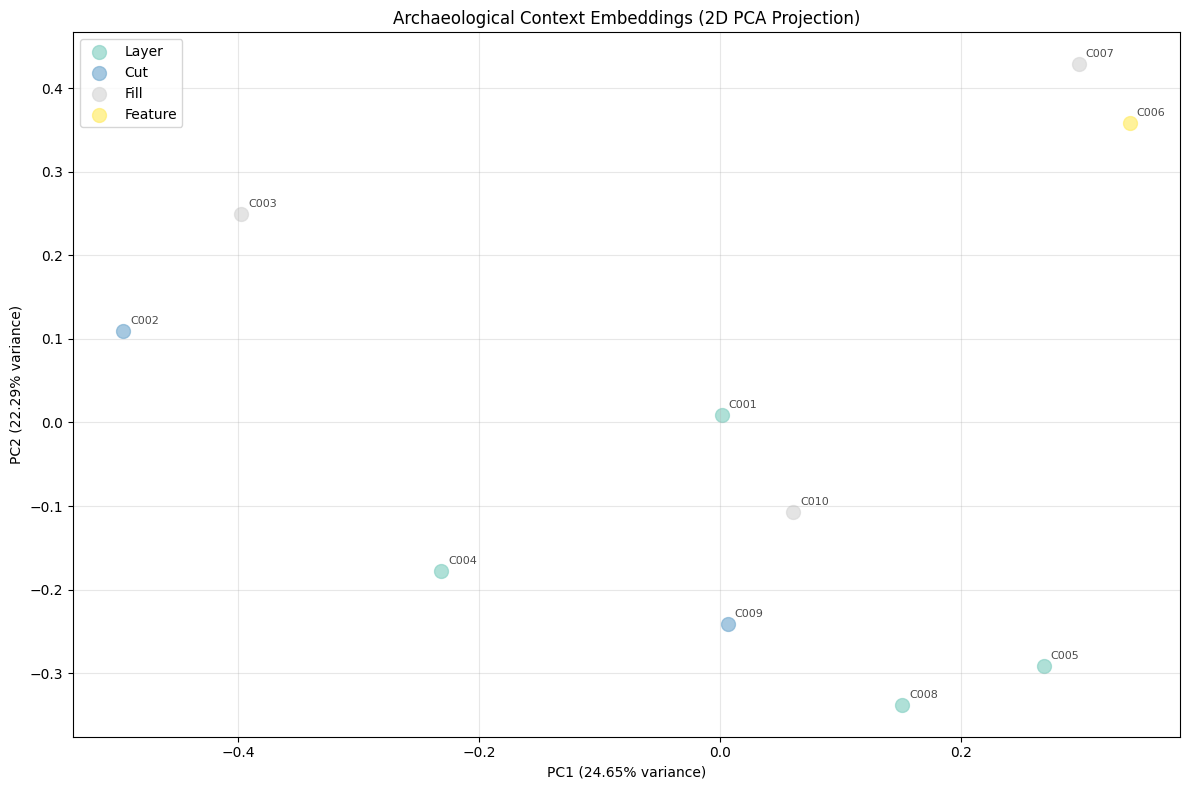

PCA explains 46.94% of total variance


In [54]:
## 4. Embedding Storage and Retrieval System

class ArchaeologicalEmbeddingStore:
    """
    A class to store and retrieve archaeological context embeddings.
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        self.embeddings_matrix = np.array(df['embedding'].tolist())
        print(f"Initialized embedding store with {len(df)} contexts")

    def search_similar_contexts(self, query_embedding: np.ndarray, top_k: int = 5) -> List[Dict]:
        """
        Find the most similar contexts to a query embedding.
        """
        # Calculate cosine similarity
        similarities = cosine_similarity([query_embedding], self.embeddings_matrix)[0]

        # Get top-k most similar indices
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        results = []
        for idx in top_indices:
            context_data = self.df.iloc[idx].to_dict()
            context_data['similarity_score'] = similarities[idx]
            results.append(context_data)

        return results

    def visualize_embeddings(self, sample_size: int = 100):
        """
        Create a 2D visualization of the embeddings using PCA.
        """
        # Sample data if too large
        if len(self.df) > sample_size:
            sample_idx = np.random.choice(len(self.df), sample_size, replace=False)
            embeddings_sample = self.embeddings_matrix[sample_idx]
            contexts_sample = self.df.iloc[sample_idx]
        else:
            embeddings_sample = self.embeddings_matrix
            contexts_sample = self.df

        # Reduce to 2D using PCA
        pca = PCA(n_components=2, random_state=42)
        embeddings_2d = pca.fit_transform(embeddings_sample)

        # Create visualization
        plt.figure(figsize=(12, 8))

        # Color by context type
        context_types = contexts_sample['Context_Type'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(context_types)))

        for i, context_type in enumerate(context_types):
            mask = contexts_sample['Context_Type'] == context_type
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=[colors[i]], label=context_type, alpha=0.7, s=100)

        plt.title('Archaeological Context Embeddings (2D PCA Projection)')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add context labels
        for i, row in contexts_sample.iterrows():
            plt.annotate(row['Context_ID'],
                        (embeddings_2d[i - contexts_sample.index[0], 0],
                         embeddings_2d[i - contexts_sample.index[0], 1]),
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=8, alpha=0.7)

        plt.tight_layout()
        plt.show()

        print(f"PCA explains {pca.explained_variance_ratio_.sum():.2%} of total variance")

# Initialize the embedding store
embedding_store = ArchaeologicalEmbeddingStore(df)

# Visualize the embeddings
embedding_store.visualize_embeddings()

In [58]:
## 5. RAG Query System

class ArchaeologicalRAGSystem:
    """
    A complete RAG system for querying archaeological context data.
    """

    def __init__(self, embedding_store, embedding_model, chat_model):
        self.embedding_store = embedding_store
        self.embedding_model = embedding_model
        self.chat_model = chat_model


    def query(self, user_query: str, top_k: int = 5, include_context: bool = True) -> Dict[str, Any]:
        """
        Process a natural language query about archaeological contexts.
        Default is 5 contexts; it would be good to work out a way for the
        code to determine the appropriate number of contexts to return.
        """
        results = {
            'query': user_query,
            'retrieved_contexts': [],
            'answer': '',
            'sources': []
        }

        try:
            # Generate embedding for the query
            if self.embedding_model:
                if isinstance(self.embedding_model, str):
                    # Using CLI interface
                    query_embedding = generate_embeddings_via_cli(user_query, self.embedding_model)
                    query_embedding = np.array(query_embedding) if query_embedding else np.random.normal(0, 1, 384)
                else:
                    # Using Python API
                    query_embedding = np.array(self.embedding_model.embed(user_query))
            else:
                # Fallback: use random embedding for demonstration
                query_embedding = np.random.normal(0, 1, 384)  # all-MiniLM-L6-v2 dimension

            # Retrieve similar contexts
            similar_contexts = self.embedding_store.search_similar_contexts(
                query_embedding, top_k=top_k
            )

            results['retrieved_contexts'] = similar_contexts

            # Prepare context for generation
            context_text = self._prepare_context_for_generation(similar_contexts)

            # Generate answer using RAG
            if self.chat_model:
                answer = self._generate_answer(user_query, context_text)
                results['answer'] = answer
            else:
                results['answer'] = "Chat model not available. Here are the most relevant contexts found:"

            # Add sources
            results['sources'] = [ctx['Context_ID'] for ctx in similar_contexts]

        except Exception as e:
            results['answer'] = f"Error processing query: {e}"

        return results

    def _prepare_context_for_generation(self, contexts: List[Dict]) -> str:
        """
        Prepare retrieved contexts for the generation step.
        """
        context_parts = []

        for i, ctx in enumerate(contexts, 1):
            # Format dating information
            dating_info = ""
            if pd.notna(ctx.get('Earliest_Date_Year')) and pd.notna(ctx.get('Latest_Date_Year')):
                earliest = f"{ctx['Earliest_Date_Year']} {ctx['Earliest_Date_Era']}"
                latest = f"{ctx['Latest_Date_Year']} {ctx['Latest_Date_Era']}"
                dating_info = f"Dated {earliest} to {latest}"

            context_part = f"""
Context {i} (ID: {ctx['Context_ID']}, Similarity: {ctx['similarity_score']:.3f}):
- Type: {ctx['Context_Type']}
- Description: {ctx['Description']}
- Dating: {dating_info} (Method: {ctx.get('Date_Type', 'Unknown')})
- Phase: {ctx.get('Phase_Name', 'Unknown')}
- Group: {ctx.get('Group_Name', 'Unknown')}
- Sub-Group: {ctx.get('Sub-Group_Name', 'Unknown')}
- Stratigraphic relationship: {ctx.get('Relationship_Type', 'Unknown')} {ctx.get('Related_Context_ID', '')}
- Temporal conflict: {ctx.get('Temporal_Conflict', False)}
- Is redundant: {ctx.get('Is_Redundant', False)}
"""
            context_parts.append(context_part)

        return "\n".join(context_parts)

    def _generate_answer(self, query: str, context: str) -> str:
        """
        Generate an answer using the retrieved context via CLI.
        """
        prompt = f"""You are an expert archaeologist analyzing stratigraphic data. Based on the following archaeological context information, please answer the user's question accurately and comprehensively.

ARCHAEOLOGICAL CONTEXTS:
{context}

USER QUESTION: {query}

Please provide a detailed answer based only on the archaeological evidence provided. Include references to specific context IDs when relevant, and explain any stratigraphic relationships or dating evidence that supports your answer.

ANSWER:"""

        try:
            # Use set_chat function to generate response via CLI
            if isinstance(self.chat_model, str):
                # chat_model is a string (model name), use CLI
                result = set_chat(prompt, self.chat_model)
                if result.returncode == 0:
                    return result.stdout.strip()
                else:
                    return f"Error generating answer: {result.stderr}"
            else:
                # Fallback for old API (shouldn't happen with updated code)
                response = self.chat_model.prompt(prompt)
                return response.text()
        except Exception as e:
            return f"Error generating answer: {e}"

    def display_results(self, results: Dict[str, Any]):
        """
        Display query results in a formatted way.
        """
        print("=" * 80)
        print(f"QUERY: {results['query']}")
        print("=" * 80)

        print(f"\nANSWER:")
        print(results['answer'])

        print(f"\nSOURCES: {', '.join(results['sources'])}")

        print(f"\nRETRIEVED CONTEXTS:")
        for i, ctx in enumerate(results['retrieved_contexts'], 1):
            # Format dating for display
            dating_display = ""
            if pd.notna(ctx.get('Earliest_Date_Year')) and pd.notna(ctx.get('Latest_Date_Year')):
                earliest = f"{ctx['Earliest_Date_Year']} {ctx['Earliest_Date_Era']}"
                latest = f"{ctx['Latest_Date_Year']} {ctx['Latest_Date_Era']}"
                dating_display = f"{earliest} to {latest}"

            print(f"\n{i}. Context {ctx['Context_ID']} (Similarity: {ctx['similarity_score']:.3f})")
            print(f"   Type: {ctx['Context_Type']}")
            print(f"   Description: {ctx['Description'][:100]}...")
            print(f"   Dating: {dating_display}")
            print(f"   Phase: {ctx.get('Phase_Name', 'Unknown')}")
            print(f"   Relationship: {ctx.get('Relationship_Type', '')} {ctx.get('Related_Context_ID', '')}")


# Initialize the RAG system
rag_system = ArchaeologicalRAGSystem(embedding_store, embedding_model, chat_model)

In [59]:
## 6. Interactive Query Interface
## This is mostly for someone using Google Colab to power this notebook

def interactive_query_session():
    """
    Run an interactive query session for archaeological data.
    """
    print("Archaeological Context RAG System")
    print("=" * 50)
    print("Ask questions about the archaeological contexts!")
    print("Type 'quit' to exit, 'help' for sample queries")
    print()

    sample_queries = [
        "What Romano-British contexts were found?",
        "Tell me about pit contexts and their fills",
        "What evidence is there for domestic activity?",
        "Describe the stratigraphic sequence in Phase 2",
        "What contexts show evidence of burning or hearth activity?",
        "Compare the medieval contexts across different groups",
        "Which contexts have dating conflicts?",
        "What construction activities are represented?",
        "Show me contexts dated using radiocarbon methods",
        "What are the latest contexts in the sequence?"
    ]

    while True:
        user_input = input("\nEnter your query: ").strip()

        if user_input.lower() == 'quit':
            print("Goodbye!")
            break

        elif user_input.lower() == 'help':
            print("\nSample queries you can try:")
            for i, query in enumerate(sample_queries, 1):
                print(f"{i}. {query}")
            continue

        elif not user_input:
            continue

        # Process the query
        print("\nProcessing query...")
        results = rag_system.query(user_input)
        rag_system.display_results(results)



# Uncomment the following line to start an interactive session
interactive_query_session()

Archaeological Context RAG System
Ask questions about the archaeological contexts!
Type 'quit' to exit, 'help' for sample queries


Enter your query: When was the site abandoned?

Processing query...
QUERY: When was the site abandoned?

ANSWER:
Based on the archaeological context information provided, the site abandonment can be inferred to have occurred during the Post-Medieval phase, specifically between 1600.0 AD and 1700.0 AD. This conclusion is supported by Context 1 (ID: C008), which is described as a "Post-medieval demolition layer with brick and tile rubble" and is dated to this time period using ceramic dating methods.

The stratigraphic relationship of Context 1 (ID: C008) also provides valuable information. It is stated that C008 "overlies C005", which means that the demolition layer (C008) was deposited on top of the medieval mortar floor surface (C005). This relationship suggests that the medieval floor surface (C005) was already in place and was subsequently covered by th

KeyboardInterrupt: Interrupted by user

In [60]:
# Demonstration queries
# with slightly convoluted language to avoid simple keyword searches
def run_demo_queries():
    """
    Run some demonstration queries to show the system in action.
    """
    demo_queries = [
        "What contexts were found dating to the occupation by Rome and what do they tell us?",
        "Describe any hearths and there associated deposits",
        "What is the stratigraphic relationship between pit contexts and surrounding layers?",
        "What evidence exists for domestic activities across different phases?",
        "Which contexts have temporal conflicts and why?",
        "Compare the dating methods used across different context types"
    ]

    print("DEMONSTRATION QUERIES")
    print("=" * 50)

    for query in demo_queries:
        print(f"\nRunning query: '{query}'")
        results = rag_system.query(query)
        rag_system.display_results(results)
        print("\n" + "-" * 80)

# Run demonstration
run_demo_queries()

DEMONSTRATION QUERIES

Running query: 'What contexts were found dating to the occupation by Rome and what do they tell us?'
QUERY: What contexts were found dating to the occupation by Rome and what do they tell us?

ANSWER:
Based on the provided archaeological context information, the occupation by Rome, also known as the Romano-British period, is represented by Context 2 (ID: C001). This context is a layer of dark brown silty clay with frequent charcoal flecks and pottery sherds, which has been dated to 100.0 AD to 400.0 AD through ceramic analysis. This dating method suggests that the layer contains ceramic materials that are characteristic of the Romano-British period, allowing for a relatively precise chronology.

The stratigraphic relationship of Context 2 (C001) indicates that it overlies Context 4 (C004), although the details of Context 4 are not provided in the given information. This relationship implies that the occupation deposit represented by Context 2 (C001) is situated a

STRATIGRAPHIC RELATIONSHIP ANALYSIS
Relationship type frequencies:
  overlies: 3
  fills: 3
  cuts: 2
  cut by: 1
  built into: 1

Data quality metrics:
  Temporal conflicts: 0
  Redundant contexts: 0

Dating methods:
  Stratigraphic: 4
  Ceramic: 2
  Architectural: 2
  Geological: 1
  Radiocarbon: 1


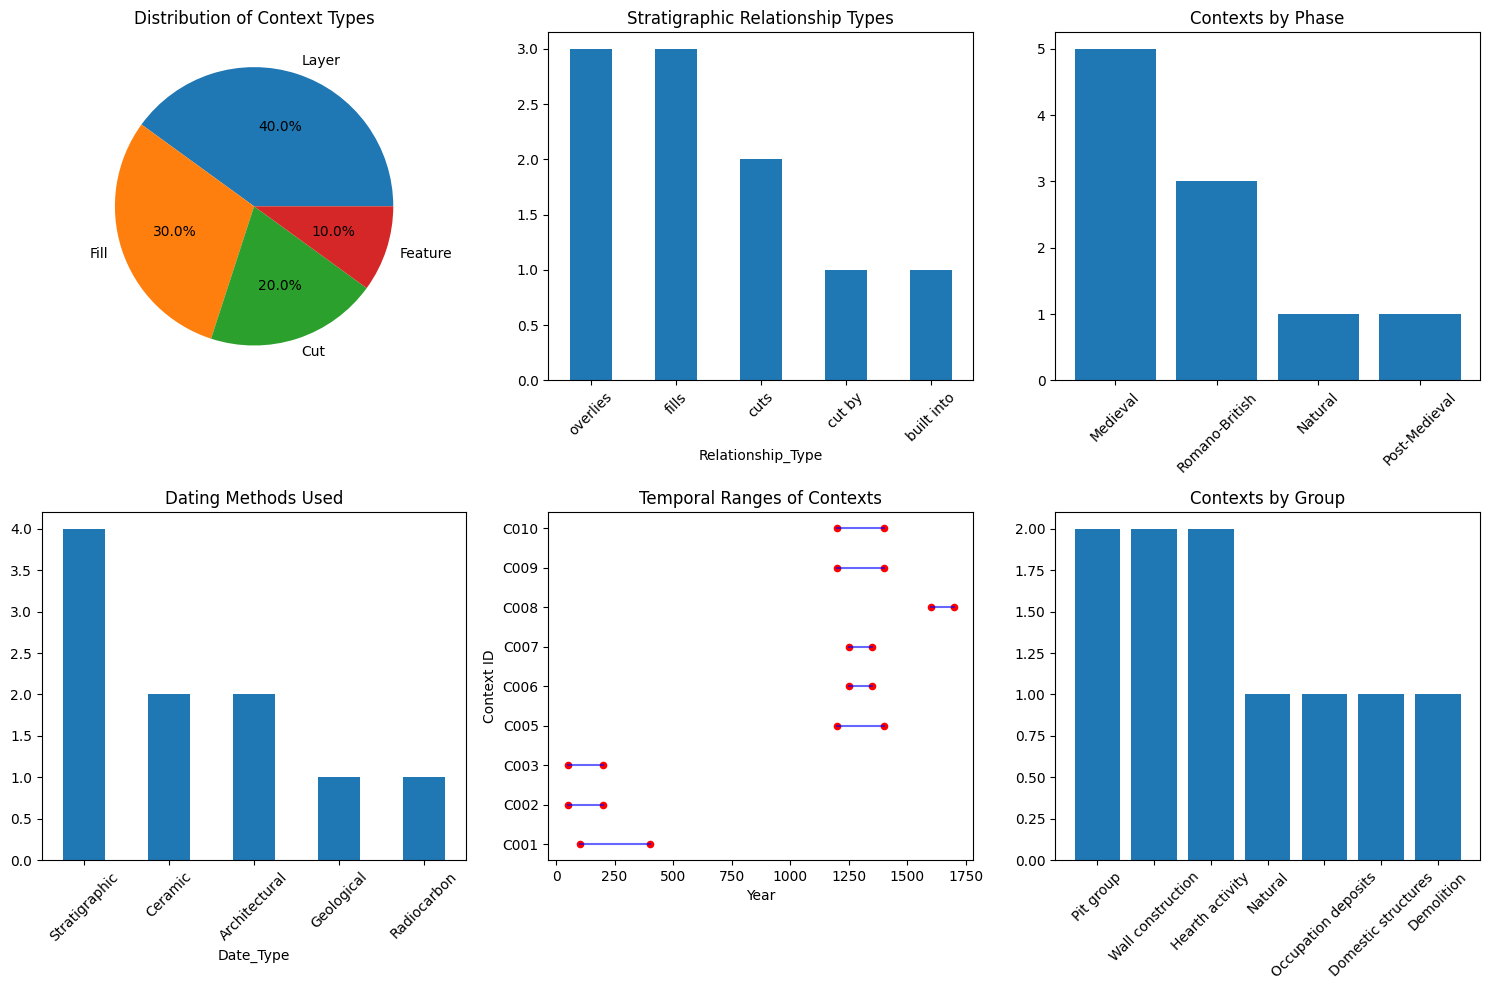


Phase analysis:
                Context_Count Dominant_Type  Earliest_Year  Latest_Year
Phase_Name                                                             
Medieval                    5          Fill         1200.0       1400.0
Natural                     1         Layer            NaN          NaN
Post-Medieval               1         Layer         1600.0       1700.0
Romano-British              3         Layer           50.0        400.0
CONTEXT NETWORK ANALYSIS
Found 8 connected components:
  Component 1: C001, C004, C002
    PHASING: P1, P0

  Component 2: C003
    PHASING: P1

  Component 3: C005
    PHASING: P2

  Component 4: C006
    PHASING: P2

  Component 5: C007
    PHASING: P2

  Component 6: C008
    PHASING: P3

  Component 7: C009
    PHASING: P2

  Component 8: C010
    PHASING: P2



In [67]:
# 7. Further Analysis

def analyze_stratigraphic_relationships(df: pd.DataFrame):
    """
    Analyze and visualize stratigraphic relationships in the dataset.
    """
    print("STRATIGRAPHIC RELATIONSHIP ANALYSIS")
    print("=" * 50)

    # Analyze relationship types
    relationship_counts = df['Relationship_Type'].value_counts()
    print("Relationship type frequencies:")
    for rel_type, count in relationship_counts.items():
        print(f"  {rel_type}: {count}")

    # Analyze temporal conflicts
    temporal_conflicts = df['Temporal_Conflict'].sum() if 'Temporal_Conflict' in df.columns else 0
    redundant_contexts = df['Is_Redundant'].sum() if 'Is_Redundant' in df.columns else 0

    print(f"\nData quality metrics:")
    print(f"  Temporal conflicts: {temporal_conflicts}")
    print(f"  Redundant contexts: {redundant_contexts}")

    # Analyze dating methods
    if 'Date_Type' in df.columns:
        dating_methods = df['Date_Type'].value_counts()
        print(f"\nDating methods:")
        for method, count in dating_methods.items():
            print(f"  {method}: {count}")

    # Visualize the data
    plt.figure(figsize=(15, 10))

    # Context types
    plt.subplot(2, 3, 1)
    context_type_counts = df['Context_Type'].value_counts()
    plt.pie(context_type_counts.values, labels=context_type_counts.index, autopct='%1.1f%%')
    plt.title('Distribution of Context Types')

    # Relationship types
    plt.subplot(2, 3, 2)
    relationship_counts.plot(kind='bar')
    plt.title('Stratigraphic Relationship Types')
    plt.xticks(rotation=45)

    # Phases
    plt.subplot(2, 3, 3)
    if 'Phase_Name' in df.columns:
        phase_counts = df['Phase_Name'].value_counts()
        plt.bar(phase_counts.index, phase_counts.values)
        plt.title('Contexts by Phase')
        plt.xticks(rotation=45)

    # Dating methods
    plt.subplot(2, 3, 4)
    if 'Date_Type' in df.columns:
        dating_methods.plot(kind='bar')
        plt.title('Dating Methods Used')
        plt.xticks(rotation=45)

    # Temporal range visualization
    plt.subplot(2, 3, 5)
    if 'Earliest_Date_Year' in df.columns and 'Latest_Date_Year' in df.columns:
        # Filter out non-numeric dates
        dated_contexts = df.dropna(subset=['Earliest_Date_Year', 'Latest_Date_Year'])
        if not dated_contexts.empty:
            for _, ctx in dated_contexts.iterrows():
                plt.plot([ctx['Earliest_Date_Year'], ctx['Latest_Date_Year']],
                        [ctx['Context_ID'], ctx['Context_ID']], 'b-', alpha=0.6)
                plt.scatter([ctx['Earliest_Date_Year'], ctx['Latest_Date_Year']],
                           [ctx['Context_ID'], ctx['Context_ID']], c='red', s=20)
            plt.xlabel('Year')
            plt.ylabel('Context ID')
            plt.title('Temporal Ranges of Contexts')

    # Groups
    plt.subplot(2, 3, 6)
    if 'Group_Name' in df.columns:
        group_counts = df['Group_Name'].value_counts()
        plt.bar(range(len(group_counts)), group_counts.values)
        plt.title('Contexts by Group')
        plt.xticks(range(len(group_counts)), group_counts.index, rotation=45)

    plt.tight_layout()
    plt.show()

    # Print phase analysis
    if 'Phase_Name' in df.columns:
        print(f"\nPhase analysis:")
        phase_analysis = df.groupby('Phase_Name').agg({
            'Context_ID': 'count',
            'Context_Type': lambda x: x.value_counts().index[0],  # Most common type
            'Earliest_Date_Year': 'min',
            'Latest_Date_Year': 'max'
        }).round(0)
        phase_analysis.columns = ['Context_Count', 'Dominant_Type', 'Earliest_Year', 'Latest_Year']
        print(phase_analysis)

def find_context_networks(df: pd.DataFrame):
    """
    Identify networks of related contexts based on stratigraphic relationships.
    """
    print("CONTEXT NETWORK ANALYSIS")
    print("=" * 50)

    # Build a simple network of relationships
    networks = {}

    for _, row in df.iterrows():
        context_id = row['Context_ID']
        related = row['Related_Context_ID'].split(',') if pd.notna(row['Related_Context_ID']) else []
        related = [ctx.strip() for ctx in related if ctx.strip()]

        networks[context_id] = related

    # Find connected components
    visited = set()
    components = []

    def dfs(context, component):
        if context in visited or context not in networks:
            return
        visited.add(context)
        component.append(context)
        for related in networks[context]:
            dfs(related, component)

    for context in networks:
        if context not in visited:
            component = []
            dfs(context, component)
            if component:
                components.append(component)

    print(f"Found {len(components)} connected components:")
    for i, component in enumerate(components, 1):
        print(f"  Component {i}: {', '.join(component)}")

        # Show the stratigraphic sequence for this component
        component_df = df[df['Context_ID'].isin(component)]
        print(f"    PHASING: {', '.join(component_df['Phase_ID'].unique())}")
        print()

# Run advanced analyses
analyze_stratigraphic_relationships(df)
find_context_networks(df)

In [63]:
df

,Context_ID,Context_Type,Description,Earliest_Date_Year,Earliest_Date_Era,Latest_Date_Year,Latest_Date_Era,Date_Type,Phase_ID,Phase_Name,Group_ID,Group_Name,Sub-Group_ID,Sub-Group_Name,Relationship_Type,Related_Context_ID,Temporal_Conflict,Is_Redundant,prepared_text,embedding
0,C001,Layer,Dark brown silty clay layer with frequent char...,100.0,AD,400.0,AD,Ceramic,P1,Romano-British,G1,Occupation deposits,SG1,General occupation,overlies,C004,False,False,"Context C001, Type: Layer | Description: Dark ...","[-0.0022556865587830544, 0.05589134246110916, ..."
1,C002,Cut,Circular pit cut with steep sides and flat bot...,50.0,AD,200.0,AD,Stratigraphic,P1,Romano-British,G2,Pit group,SG2,Pit cutting and filling,cuts,C004,False,False,"Context C002, Type: Cut | Description: Circula...","[-0.03904779255390167, 0.0598103292286396, -0...."
2,C003,Fill,"Light grey sandy fill of pit C002, containing ...",50.0,AD,200.0,AD,Stratigraphic,P1,Romano-British,G2,Pit group,SG2,Pit cutting and filling,fills,C002,False,False,"Context C003, Type: Fill | Description: Light ...","[-0.08637669682502747, 0.04328100010752678, -0..."
3,C004,Layer,Compact yellow clay natural subsoil layer,NaN,None,NaN,None,Geological,P0,Natural,G0,Natural,None,None,cut by,C002,False,False,"Context C004, Type: Layer | Description: Compa...","[-0.0745324045419693, 0.08791496604681015, 0.0..."
4,C005,Layer,Medieval mortar floor surface with tile fragments,1200.0,AD,1400.0,AD,Architectural,P2,Medieval,G3,Domestic structures,SG3,Floor surfaces,overlies,C004,False,False,"Context C005, Type: Layer | Description: Medie...","[-0.10213303565979004, 0.12052890658378601, 0...."
5,C006,Feature,Stone-lined hearth with evidence of burning an...,1250.0,AD,1350.0,AD,Radiocarbon,P2,Medieval,G4,Hearth activity,SG4,Hearth construction and use,built into,C005,False,False,"Context C006, Type: Feature | Description: Sto...","[-0.009370672516524792, 0.14452221989631653, 0..."
6,C007,Fill,"Ash and charcoal fill of hearth C006, rich in ...",1250.0,AD,1350.0,AD,Stratigraphic,P2,Medieval,G4,Hearth activity,SG4,Hearth construction and use,fills,C006,False,False,"Context C007, Type: Fill | Description: Ash an...","[-0.00016425596550107002, 0.11362960189580917,..."
7,C008,Layer,Post-medieval demolition layer with brick and ...,1600.0,AD,1700.0,AD,Ceramic,P3,Post-Medieval,G5,Demolition,SG5,Site abandonment,overlies,C005,False,False,"Context C008, Type: Layer | Description: Post-...","[-0.073366180062294, 0.11150677502155304, 0.03..."
8,C009,Cut,Rectangular foundation trench for stone wall,1200.0,AD,1400.0,AD,Architectural,P2,Medieval,G6,Wall construction,SG6,Foundation construction,cuts,C005,False,False,"Context C009, Type: Cut | Description: Rectang...","[-0.06563512980937958, 0.08968332409858704, 0...."
9,C010,Fill,Stone and mortar fill of foundation trench C009,1200.0,AD,1400.0,AD,Stratigraphic,P2,Medieval,G6,Wall construction,SG6,Foundation construction,fills,C009,False,False,"Context C010, Type: Fill | Description: Stone ...","[-0.07496478408575058, 0.07007502764463425, 0...."


In [ ]:
## 8. Export and Persistence
def save_embeddings_to_database(df: pd.DataFrame, db_path: str = 'archaeological_contexts.db'):
    """
    Save the context data and embeddings to a SQLite database for persistence.
    """
    conn = sqlite3.connect(db_path)

    # Prepare data for storage
    df_to_save = df.copy()
    df_to_save['embedding_json'] = df_to_save['embedding'].apply(json.dumps)
    df_to_save = df_to_save.drop('embedding', axis=1)

    # Save to database
    df_to_save.to_sql('archaeological_contexts', conn, if_exists='replace', index=False)

    conn.close()
    print(f"Saved {len(df)} contexts to database: {db_path}")

def load_embeddings_from_database(db_path: str = 'archaeological_contexts.db') -> pd.DataFrame:
    """
    Load context data and embeddings from SQLite database.
    """
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT * FROM archaeological_contexts", conn)
    conn.close()

    # Convert embeddings back from JSON
    df['embedding'] = df['embedding_json'].apply(json.loads)
    df = df.drop('embedding_json', axis=1)

    print(f"Loaded {len(df)} contexts from database: {db_path}")
    return df

def export_results_to_csv(results_list: List[Dict], output_path: str = 'query_results.csv'):
    """
    Export query results to CSV for further analysis.
    """
    # Flatten results for CSV export
    flattened_results = []

    for result in results_list:
        for ctx in result['retrieved_contexts']:
            flattened_results.append({
                'query': result['query'],
                'context_id': ctx['Context_ID'],
                'similarity_score': ctx['similarity_score'],
                'context_type': ctx['Context_Type'],
                'phase_name': ctx.get('Phase_Name', ''),
                'group_name': ctx.get('Group_Name', ''),
                'relationship_type': ctx.get('Relationship_Type', ''),
                'related_context_id': ctx.get('Related_Context_ID', ''),
                'description': ctx['Description'][:100] + '...'  # Truncate for CSV
            })

    results_df = pd.DataFrame(flattened_results)
    results_df.to_csv(output_path, index=False)
    print(f"Exported {len(results_df)} query results to: {output_path}")

# Save current work
save_embeddings_to_database(df)